In [1]:
import torch.nn.functional as F
import torch
import torchvision
from matplotlib import pyplot as plt
from torchvision import utils
import numpy as np
import torch.nn as nn
import os
import pandas as pd
import PIL
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/STRATIFIED MULTI-INPUT")

myseed = 0
torch.manual_seed(myseed)
np.random.seed(myseed)
generator=torch.Generator()
generator.manual_seed(myseed)

%matplotlib inline

2023-01-10 10:27:20.882181: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

cuda


In [3]:
data_path = "./"

In [4]:
images = os.listdir(f"{data_path}DATASET")
print(images)

['P_2_62.png', 'P_232.png', 'P_720.png', 'P_3_416.png', 'P_2_67.png', 'P_2_9.png', 'P_98.png', 'P_759.png', 'P_667.png', 'P_2_19.png', 'P_3_463.png', 'P_3_274.png', 'P_795.png', 'P_619.png', 'P_289.png', 'P_3_306.png', 'P_493.png', 'P_486.png', 'P_1_154.png', 'P_3_5.png', 'P_2_88.png', 'P_3_204.png', 'P_412.png', 'P_1_112.png', 'P_3_273.png', 'P_460.png', 'P_130.png', 'P_654.png', 'P_405.png', 'P_3_290.png', 'P_3_396.png', 'P_3_180.png', 'P_3_115.png', 'P_3_17.png', 'P_45.png', 'P_782.png', 'P_827.png', 'P_1_107.png', 'P_753.png', 'P_786.png', 'P_507.png', 'P_3_103.png', 'P_719.png', 'P_497.png', 'P_310.png', 'P_743.png', 'P_446.png', 'P_3_342.png', 'P_3_421.png', 'P_13.png', 'P_382.png', 'P_1_8.png', 'P_2_93.png', 'P_3_410.png', 'P_442.png', 'P_2_70.png', 'P_559.png', 'P_19.png', 'P_245.png', 'P_2.png', 'P_42.png', 'P_3_500.png', 'P_3_409.png', 'P_3_203.png', 'P_3_297.png', 'P_1_143.png', 'P_3_21.png', 'P_328.png', 'P_3_359.png', 'P_3_83.png', 'P_2_27.png', 'P_2_102.png', 'P_3_134.png

In [5]:
len(images)

1589

In [6]:
df = pd.read_excel("trainANDtest.xls")

In [7]:
df

,Unnamed: 0,Row_number,ImageFile,Hospital,Age,Sex,PositivityAtAdmission,Temp_C,DaysFever,Cough,...,pH,HighBloodPressure,Diabetes,Dementia,BPCO,Cancer,ChronicKidneyDisease,RespiratoryFailure,Prognosis,Death
0,0,82.0,P_102.png,1,72,1,1,37.3,3,1,...,7.46,0,0,0,0,1,0,0,1,0
1,1,228.0,P_131.png,4,35,0,1,39.3,3,1,...,7.46,1,0,0,0,0,0,0,0,0
2,2,229.0,P_132.png,4,57,0,1,37.0,3,0,...,7.42,0,0,0,0,0,0,0,0,0
3,3,96.0,P_117.png,1,39,1,1,37.2,2,1,...,7.38,0,0,0,0,0,0,0,0,0
4,4,112.0,P_16.png,1,44,0,1,38.0,3,1,...,7.47,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584,481,1474.0,P_3_432.png,6,84,1,1,37.0,2,0,...,7.46,1,0,1,0,0,0,0,0,0
1585,482,1228.0,P_3_105.png,6,51,0,1,38.0,3,0,...,7.44,0,1,0,0,0,0,0,1,0
1586,483,1466.0,P_3_233.png,6,70,1,1,36.4,2,1,...,7.50,1,0,0,0,0,0,0,0,0
1587,484,1210.0,P_3_414.png,6,90,0,1,36.2,4,0,...,7.42,0,1,0,0,0,0,0,0,0


In [8]:
del df["Row_number"]
del df["Unnamed: 0"]

In [9]:
df.columns

Index(['ImageFile', 'Hospital', 'Age', 'Sex', 'PositivityAtAdmission',
       'Temp_C', 'DaysFever', 'Cough', 'DifficultyInBreathing', 'WBC', 'RBC',
       'CRP', 'Glucose', 'LDH', 'INR', 'PaO2', 'PaCO2', 'pH',
       'HighBloodPressure', 'Diabetes', 'Dementia', 'BPCO', 'Cancer',
       'ChronicKidneyDisease', 'RespiratoryFailure', 'Prognosis', 'Death'],
      dtype='object')

In [16]:
class ImageDataset(Dataset):
    """Tabular and Image dataset."""

    def __init__(self, indices, image_dir, transform=None):
        self.image_dir = image_dir
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        tabular = self.indices.iloc[idx, 0:]

        y = tabular["Prognosis"]

        image = PIL.Image.open(f"{self.image_dir}/{tabular['ImageFile']}")
        image = image.convert('L')
        image = np.array(image)
        #image = image[..., :3]

        image = transforms.functional.to_tensor(image)

        tabular = tabular[['Age', 'Sex', 'PositivityAtAdmission',
       'Temp_C', 'DaysFever', 'Cough', 'DifficultyInBreathing', 'WBC', 'RBC',
       'CRP', 'Glucose', 'LDH', 'INR', 'PaO2', 'PaCO2', 'pH',
       'HighBloodPressure', 'Diabetes', 'Dementia', 'BPCO', 'Cancer',
       'ChronicKidneyDisease', 'RespiratoryFailure']]
        tabular = tabular.tolist()
        tabular = torch.FloatTensor(tabular)
        
        if self.transform:
            image = self.transform(image)
        
        return image, tabular, y
    
    

In [17]:
from torchvision import transforms as T
my_transform = T.Compose([T.Resize((256,256)),
                          T.RandomApply(
                            [T.RandomHorizontalFlip(),
                             T.RandomCrop(256, padding=4)],
                            p=.5
                          )])

In [18]:
from sklearn.model_selection import train_test_split

tv_idx, test_idx = train_test_split(np.arange(len(df["Prognosis"])), test_size=0.2, shuffle=True, stratify=df["Prognosis"])

In [19]:
train_val_df = df.iloc[tv_idx]
train_val = ImageDataset(indices=train_val_df, image_dir=f"{data_path}DATASET", transform=my_transform)

len(train_val)

1271

In [20]:
test_df = df.iloc[test_idx]
test_set = ImageDataset(indices=test_df, image_dir=f"{data_path}DATASET", transform=my_transform)

len(test_set)

318

In [21]:
i = 3
print(f"{train_val[i][0].size()}, label = {train_val[i][1]}")

torch.Size([1, 256, 256]), label = tensor([ 48.0000,   0.0000,   1.0000,  39.0000,   3.0000,   1.0000,   1.0000,
          4.1600,   5.5200,  39.0000,  96.0000, 214.0000,   1.3000,  68.0000,
         32.0000,   7.4900,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000])


In [22]:
torch.cuda.is_available()

True

In [23]:
dev = torch.device('cuda')
print(dev)

cuda


# 3. MULTI INPUT IMMAGINI E TESTO

In [24]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
               
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, in_channels=1, num_classes=2):
        super(ResNet, self).__init__()
        torch.manual_seed(myseed)
        self.in_planes = 64

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.expansion, 10) #qui ho cambiato da num_classes a 10, per far cat con testo
        #TESTO
        self.relu = nn.ReLU()
        self.ln1 = nn.Linear(23, 50) #23 sono le colonne in input
        self.ln2 = nn.Linear(50, 50)
        self.ln3 = nn.Linear(50, 10)
        self.ln4 = nn.Linear(20, 1) #20 perchè 10 derivano da img e 10 da tab

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, tab):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = self.relu(out)
        
        tab = self.ln1(tab)
        tab = self.relu(tab)
        tab = self.ln2(tab)
        tab = self.relu(tab)
        tab = self.ln3(tab)
        tab = self.relu(tab)
        
        out = torch.cat((out, tab), dim=1)
        out = self.relu(out)
        
        out = self.ln4(out)
        
        return out
    

def ResNet18(in_channels, num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], in_channels=in_channels, num_classes=num_classes)

model = ResNet18(1,1)
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [25]:
# Define an optimizier
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
# Define a loss 
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.01, epochs=5, steps_per_epoch=350)


In [26]:
def train(net, loaders, optimizer, criterion, epochs=500, dev=dev, save_param = False, model_name="only-images"):
    torch.manual_seed(myseed)
    try:
        net = net.to(dev)
        #print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Store the best val accuracy
        best_val_accuracy = 0

        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                if split == "train":
                  net.train()
                else:
                  net.eval()
                # Process each batch
                for (image, tabular, labels) in loaders[split]:
                    # Move to CUDA
                    image = image.to(dev)
                    tabular = tabular.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(image, tabular)
                    pred = pred.double()
                    #pred = pred.squeeze(dim=1) # Output shape is [Batch size, 1], but we want [Batch size]
                    labels = labels.unsqueeze(1)
                    labels = labels.float()
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    #pred_labels = pred.argmax(1) + 1
                    pred_labels = (pred >= 0).long() # Binarize predictions to 0 and 1
                    batch_accuracy = (pred_labels == labels).sum().item()/image.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
                scheduler.step()
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            # Store params at the best validation accuracy
            if save_param and epoch_accuracy["val"] > best_val_accuracy:
              #torch.save(net.state_dict(), f"{net.__class__.__name__}_best_val.pth")
              torch.save(net.state_dict(), f"{model_name}_best_val.pth")
              best_val_accuracy = epoch_accuracy["val"]

            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
                
            writer.add_scalar("Train Loss", epoch_loss['train'], epoch)
            writer.add_scalar("Valid Loss", epoch_loss['val'], epoch)
            writer.add_scalar("Test Loss", epoch_loss['test'], epoch)
            writer.add_scalar("Train Accuracy", epoch_accuracy['train'], epoch)
            writer.add_scalar("Valid Accuracy", epoch_accuracy['val'], epoch)
            writer.add_scalar("Test Accuracy", epoch_accuracy['test'], epoch)
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},",
                  f"LR={optimizer.param_groups[0]['lr']:.5f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

In [27]:
def reset_weights(m):

    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [28]:
test_loader  = DataLoader(test_set,  batch_size=8, num_workers=2, drop_last=False, shuffle=False, generator=generator)

In [29]:
tv_labels = train_val_df['Prognosis'].tolist()

------------fold no---------0----------------------
Total samples in hospital A: 99
Total samples in hospital B: 76
Total samples in hospital C: 120
Total samples in hospital D: 115
Total samples in hospital E: 66
Total samples in hospital F: 540


/home/lmancuso/anaconda3/envs/openfl/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch 1: TrL=0.6388, TrA=0.6516, VL=0.5694, VA=0.6535, TeL=0.6090, TeA=0.6854, LR=0.00040,
Epoch 2: TrL=0.5967, TrA=0.6998, VL=0.5716, VA=0.6964, TeL=0.5872, TeA=0.6948, LR=0.00040,
Epoch 3: TrL=0.5723, TrA=0.7175, VL=0.5533, VA=0.6657, TeL=0.5740, TeA=0.6740, LR=0.00041,
Epoch 4: TrL=0.5587, TrA=0.7234, VL=0.5424, VA=0.6964, TeL=0.5778, TeA=0.6917, LR=0.00041,
Epoch 5: TrL=0.5532, TrA=0.7234, VL=0.5350, VA=0.6730, TeL=0.5949, TeA=0.7052, LR=0.00042,
Epoch 6: TrL=0.5581, TrA=0.7333, VL=0.5408, VA=0.7042, TeL=0.5466, TeA=0.7198, LR=0.00043,
Epoch 7: TrL=0.5430, TrA=0.7293, VL=0.5333, VA=0.6892, TeL=0.5546, TeA=0.7208, LR=0.00044,
Epoch 8: TrL=0.5372, TrA=0.7313, VL=0.5307, VA=0.6925, TeL=0.5439, TeA=0.7365, LR=0.00045,
Epoch 9: TrL=0.5291, TrA=0.7283, VL=0.5354, VA=0.6769, TeL=0.5447, TeA=0.7146, LR=0.00046,
Epoch 10: TrL=0.5344, TrA=0.7352, VL=0.5306, VA=0.6735, TeL=0.5476, TeA=0.7146, LR=0.00048,
Epoch 11: TrL=0.5287, TrA=0.7362, VL=0.5584, VA=0.6814, TeL=0.5407, TeA=0.7031, LR=0.0004

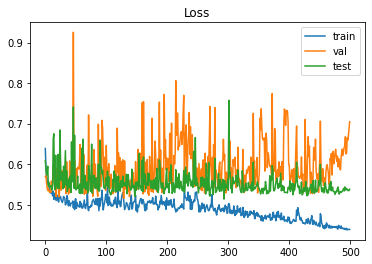

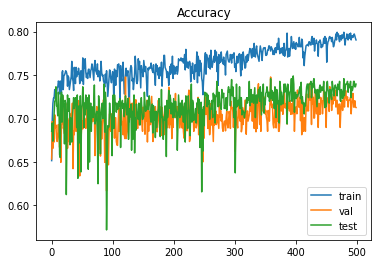

------------fold no---------1----------------------
Total samples in hospital A: 87
Total samples in hospital B: 81
Total samples in hospital C: 117
Total samples in hospital D: 95
Total samples in hospital E: 86
Total samples in hospital F: 551
Epoch 1: TrL=0.6263, TrA=0.6654, VL=0.6071, VA=0.6732, TeL=0.6298, TeA=0.6510, LR=0.00040,
Epoch 2: TrL=0.5984, TrA=0.6919, VL=0.5921, VA=0.7174, TeL=0.6147, TeA=0.6792, LR=0.00040,
Epoch 3: TrL=0.5858, TrA=0.7136, VL=0.5647, VA=0.7422, TeL=0.5846, TeA=0.7167, LR=0.00041,
Epoch 4: TrL=0.5750, TrA=0.7146, VL=0.5597, VA=0.7344, TeL=0.5800, TeA=0.6979, LR=0.00041,
Epoch 5: TrL=0.5674, TrA=0.7165, VL=0.5886, VA=0.7331, TeL=0.6189, TeA=0.6698, LR=0.00042,
Epoch 6: TrL=0.5689, TrA=0.7185, VL=0.5548, VA=0.7344, TeL=0.5806, TeA=0.7042, LR=0.00043,
Epoch 7: TrL=0.5636, TrA=0.7195, VL=0.5642, VA=0.7383, TeL=0.5877, TeA=0.7115, LR=0.00044,
Epoch 8: TrL=0.5638, TrA=0.7146, VL=0.5555, VA=0.7331, TeL=0.5776, TeA=0.6948, LR=0.00045,
Epoch 9: TrL=0.5655, TrA=0

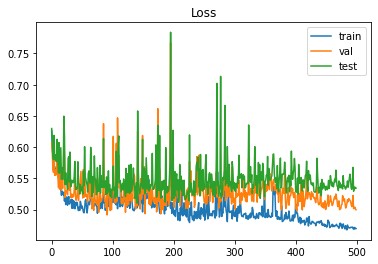

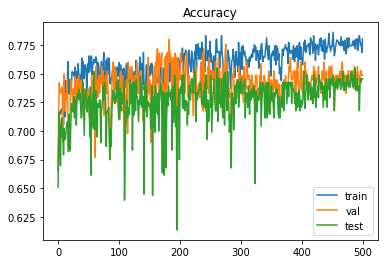

------------fold no---------2----------------------
Total samples in hospital A: 82
Total samples in hospital B: 79
Total samples in hospital C: 131
Total samples in hospital D: 99
Total samples in hospital E: 81
Total samples in hospital F: 545
Epoch 1: TrL=0.6173, TrA=0.6781, VL=0.6118, VA=0.7227, TeL=0.5955, TeA=0.6781, LR=0.00040,
Epoch 2: TrL=0.5735, TrA=0.7037, VL=0.6291, VA=0.7057, TeL=0.6056, TeA=0.6760, LR=0.00040,
Epoch 3: TrL=0.5656, TrA=0.7136, VL=0.5908, VA=0.7253, TeL=0.5835, TeA=0.6875, LR=0.00041,
Epoch 4: TrL=0.5581, TrA=0.7096, VL=0.5882, VA=0.7448, TeL=0.5715, TeA=0.7000, LR=0.00041,
Epoch 5: TrL=0.5561, TrA=0.7057, VL=0.5925, VA=0.7318, TeL=0.5760, TeA=0.6979, LR=0.00042,
Epoch 6: TrL=0.5567, TrA=0.7116, VL=0.5736, VA=0.7604, TeL=0.5685, TeA=0.6906, LR=0.00043,
Epoch 7: TrL=0.5519, TrA=0.7274, VL=0.5808, VA=0.7630, TeL=0.5719, TeA=0.6979, LR=0.00044,
Epoch 8: TrL=0.5484, TrA=0.7185, VL=0.5722, VA=0.7708, TeL=0.5687, TeA=0.7073, LR=0.00045,
Epoch 9: TrL=0.5431, TrA=0

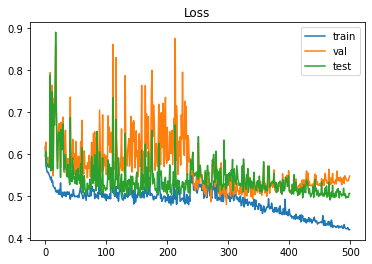

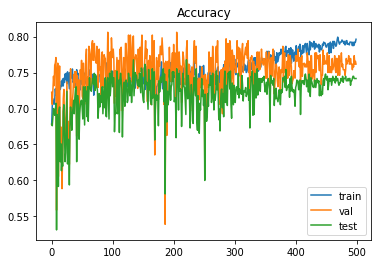

------------fold no---------3----------------------
Total samples in hospital A: 94
Total samples in hospital B: 76
Total samples in hospital C: 106
Total samples in hospital D: 108
Total samples in hospital E: 70
Total samples in hospital F: 563
Epoch 1: TrL=0.6410, TrA=0.6270, VL=0.5891, VA=0.7070, TeL=0.6116, TeA=0.6719, LR=0.00040,
Epoch 2: TrL=0.5977, TrA=0.7057, VL=0.5711, VA=0.7188, TeL=0.5875, TeA=0.7000, LR=0.00040,
Epoch 3: TrL=0.5812, TrA=0.7156, VL=0.5553, VA=0.7161, TeL=0.5923, TeA=0.6792, LR=0.00041,
Epoch 4: TrL=0.5797, TrA=0.7087, VL=0.5683, VA=0.7122, TeL=0.5756, TeA=0.7073, LR=0.00041,
Epoch 5: TrL=0.5752, TrA=0.7185, VL=0.5537, VA=0.7227, TeL=0.5982, TeA=0.6760, LR=0.00042,
Epoch 6: TrL=0.5605, TrA=0.7205, VL=0.5505, VA=0.7227, TeL=0.5809, TeA=0.6969, LR=0.00043,
Epoch 7: TrL=0.5595, TrA=0.7224, VL=0.5543, VA=0.7188, TeL=0.5716, TeA=0.7135, LR=0.00044,
Epoch 8: TrL=0.5533, TrA=0.7156, VL=0.5483, VA=0.7109, TeL=0.6128, TeA=0.6667, LR=0.00045,
Epoch 9: TrL=0.5511, TrA=

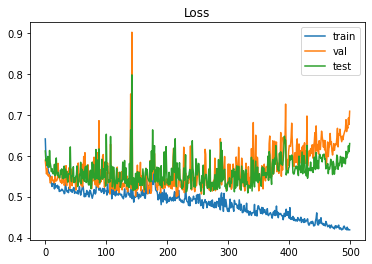

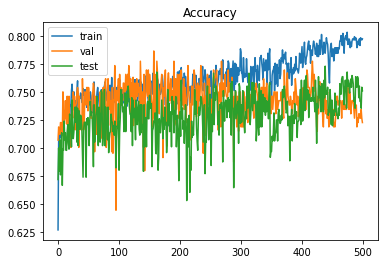

------------fold no---------4----------------------
Total samples in hospital A: 118
Total samples in hospital B: 104
Total samples in hospital C: 130
Total samples in hospital D: 139
Total samples in hospital E: 101
Total samples in hospital F: 425
Epoch 1: TrL=0.6195, TrA=0.6644, VL=0.6081, VA=0.6758, TeL=0.6008, TeA=0.6792, LR=0.00040,
Epoch 2: TrL=0.5830, TrA=0.7028, VL=0.6102, VA=0.6758, TeL=0.6075, TeA=0.6823, LR=0.00040,
Epoch 3: TrL=0.5736, TrA=0.7195, VL=0.5933, VA=0.6836, TeL=0.5870, TeA=0.7010, LR=0.00041,
Epoch 4: TrL=0.5702, TrA=0.7283, VL=0.5850, VA=0.7005, TeL=0.5778, TeA=0.7042, LR=0.00041,
Epoch 5: TrL=0.5642, TrA=0.7274, VL=0.5766, VA=0.7018, TeL=0.5691, TeA=0.7010, LR=0.00042,
Epoch 6: TrL=0.5596, TrA=0.7224, VL=0.5876, VA=0.6823, TeL=0.5856, TeA=0.6698, LR=0.00043,
Epoch 7: TrL=0.5571, TrA=0.7293, VL=0.6299, VA=0.6562, TeL=0.6055, TeA=0.6750, LR=0.00044,
Epoch 8: TrL=0.5511, TrA=0.7372, VL=0.5916, VA=0.6992, TeL=0.5725, TeA=0.6906, LR=0.00045,
Epoch 9: TrL=0.5561, T

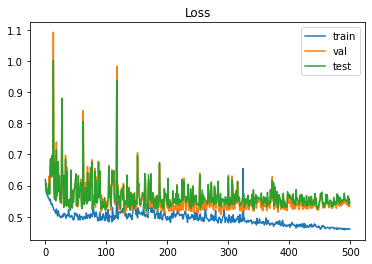

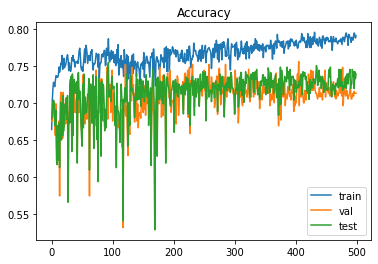

In [30]:
skf = StratifiedKFold(n_splits=5)
epochs=500
for fold,(train_idx, val_idx) in enumerate(skf.split(train_val, tv_labels)):
    writer = SummaryWriter("runs/STRATIFIED MULTI-INPUT", filename_suffix=f"_F{fold}_E{epochs}_")
    print('------------fold no---------{}----------------------'.format(fold))   
    train_df = df.iloc[train_idx]
    train_set = ImageDataset(indices=train_df, image_dir=f"{data_path}DATASET", transform=my_transform)

    val_df = df.iloc[val_idx]
    val_set = ImageDataset(indices=val_df, image_dir=f"{data_path}DATASET", transform=my_transform)
    
    print("Total samples in hospital A:",len(df.iloc[train_idx][df.iloc[train_idx]["Hospital"]==1]))
    print("Total samples in hospital B:",len(df.iloc[train_idx][df.iloc[train_idx]["Hospital"]==2]))
    print("Total samples in hospital C:",len(df.iloc[train_idx][df.iloc[train_idx]["Hospital"]==3]))
    print("Total samples in hospital D:",len(df.iloc[train_idx][df.iloc[train_idx]["Hospital"]==4]))
    print("Total samples in hospital E:",len(df.iloc[train_idx][df.iloc[train_idx]["Hospital"]==5]))
    print("Total samples in hospital F:",len(df.iloc[train_idx][df.iloc[train_idx]["Hospital"]==6]))
    
    train_loader = DataLoader(train_set, batch_size=8, num_workers=2, drop_last=True, shuffle=True, generator=generator)
    val_loader   = DataLoader(val_set,   batch_size=8, num_workers=2, drop_last=False, shuffle=False, generator=generator)
    
    # Define dictionary of loaders
    loaders = {"train": train_loader,
               "val": val_loader,
               "test": test_loader}

    # Define an optimizier
    import torch.optim as optim
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)
    # Define a loss 
    criterion = nn.BCEWithLogitsLoss()
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.01, epochs=5, steps_per_epoch=350)
    
    
    #model, optimizer = ipex.optimize(model, optimizer=optimizer,dtype=torch.double)
    #model = model.float()
    # Train model
    train(model, loaders, optimizer, criterion, epochs=500, dev=dev)
    writer.flush()
    writer.close()
    model.apply(reset_weights)